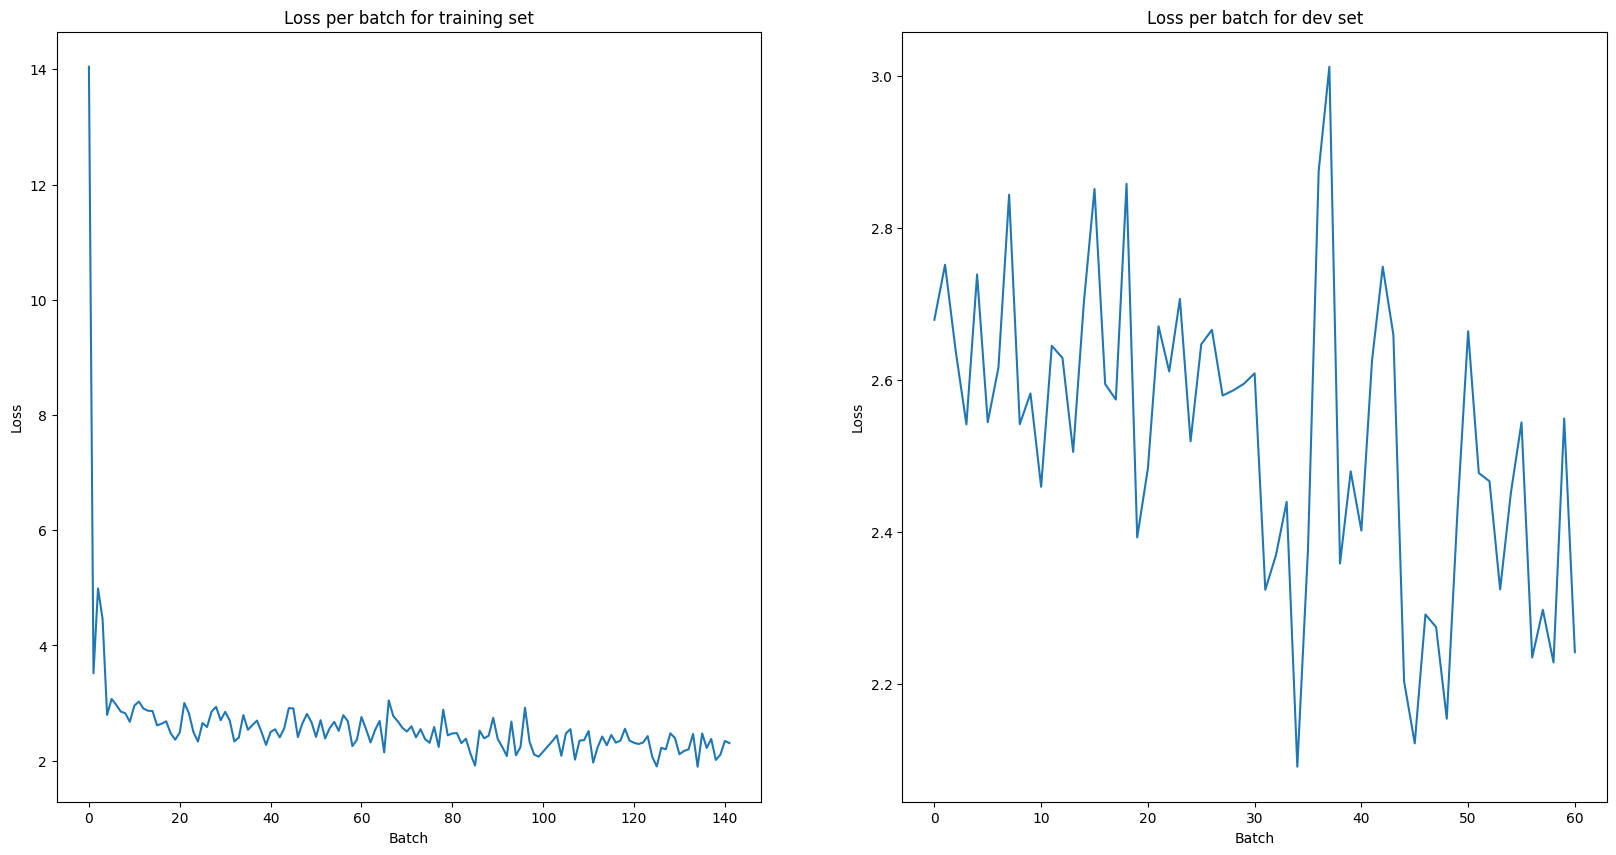

In [20]:
import pickle
import matplotlib.pyplot as plt
tracker_path = './checkpoints/english_train_dev_tracker.pkl'

with open(tracker_path, 'rb') as f:
    tracker = pickle.load(f)

tracker_keys = ['loss_per_batch', 'loss_per_epoch', 'time_per_epoch', 'time_per_batch', 'bleu_per_epoch', 'loss_per_batch_dev', 'loss_per_epoch_dev', 'time_per_epoch_dev', 'time_per_batch_dev', 'bleu_per_epoch_dev']

#sample loss per batch for training and dev set every x batches
x = 100
sampled_loss_per_batch = tracker['loss_per_batch'][::x]
x = 100
sampled_loss_per_batch_dev = tracker['loss_per_batch_dev'][::x]

#plot loss per batch for training and dev set side by side 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(sampled_loss_per_batch)
ax1.set_title('Loss per batch for training set')
ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss')
ax2.plot(sampled_loss_per_batch_dev)
ax2.set_title('Loss per batch for dev set')
ax2.set_xlabel('Batch')
ax2.set_ylabel('Loss')
plt.show()





In [1]:
from bleu import BLEU

args_path = './checkpoints/english_train_dev_args.json'
model_path = './checkpoints/english_train_dev-008.pt'

bleu_obj = BLEU(args_path, model_path, use_eval_data=True)

In [3]:
n = 600
score_on_eval = bleu_obj.calculate_bleu(n=n)

print(f'socre on {n} sample from Google dev set: {score_on_eval:.4f}')

100%|██████████| 600/600 [04:36<00:00,  2.17it/s]

The BLEU for Langauge english score is 3.5545209203953885
socre on 600 sample from Google dev set: 3.5545


In [1]:
from dataset import ClipGPTFlickr8kDataset
from bleu import BLEU

args_path = './checkpoints/english_train_dev_args.json'
tracker_path = './checkpoints/english_train_dev_tracker.json'
model_path = './checkpoints/english_train_dev-008.pt'
bleu_obj = BLEU(args_path, model_path, use_eval_data=False)
args = bleu_obj.args
all_img_paths = bleu_obj.sample_images_paths
num_samples = len(all_img_paths)
dev_ratio = args.dev_ratio
train_size = int((1 - dev_ratio) * num_samples)
dev_size = num_samples - train_size
train_indices = list(range(train_size))
dev_indices = list(range(train_size, num_samples))
print(f'number of dev samples: {len(dev_indices)}')


number of dev samples: 2428


In [8]:
num_samples_to_eval = 600
n = dev_indices[:num_samples_to_eval]
score_on_eval = bleu_obj.calculate_bleu(n=n)
print(f'socre on {num_samples_to_eval} sample from  dev set split: {score_on_eval:.4f}')

100%|██████████| 600/600 [04:41<00:00,  2.13it/s]

The BLEU for Langauge english score is 2.254296289729627
socre on 600 sample from  dev set split: 2.2543


In [9]:
num_samples_to_eval = 600
n = train_indices[:num_samples_to_eval]
score_on_eval = bleu_obj.calculate_bleu(n=n)
print(f'socre on {num_samples_to_eval} sample from  train set split: {score_on_eval:.4f}')

100%|██████████| 600/600 [04:29<00:00,  2.23it/s]

The BLEU for Langauge english score is 23.21962026887038
socre on 600 sample from  train set split: 23.2196


In [4]:
n_1_gram_weight = 0.9
n_2_gram_weight = 0.1
n_3_gram_weight = 0.0
n_4_gram_weight = 0.0

weights = [n_1_gram_weight, n_2_gram_weight, n_3_gram_weight, n_4_gram_weight]
num_samples_to_eval = 50
n = dev_indices[:num_samples_to_eval]
score_on_eval = bleu_obj.calculate_bleu(n=n, ngram_weights=weights)
print(f'socre on {num_samples_to_eval} sample from  dev set split: {score_on_eval:.4f} with weights: {weights}')

100%|██████████| 50/50 [00:22<00:00,  2.24it/s]

The BLEU for Langauge english score is 28.36980672830488
socre on 50 sample from  dev set split: 28.3698 with weights: [0.9, 0.1, 0.0, 0.0]


In [8]:
n_1_gram_weight = 0.0
n_2_gram_weight = 1.0
n_3_gram_weight = 0.0
n_4_gram_weight = 0.0

weights = [n_1_gram_weight, n_2_gram_weight, n_3_gram_weight, n_4_gram_weight]
num_samples_to_eval = 50
n = dev_indices[:num_samples_to_eval]

belu_scores = []
for i in range(num_samples_to_eval):
    k = [n[i]]
    score_on_eval = bleu_obj.calculate_bleu(n=k, ngram_weights=weights)
    belu_scores.append(score_on_eval)

belu_scores = sorted(belu_scores, reverse=True)
for i in range(len(belu_scores)):
    print(f'{i+1}th best score: {belu_scores[i]:.4f}')

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


The BLEU for Langauge english score is 1.9636207881546135e-306


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


The BLEU for Langauge english score is 1.5292694074701024e-306


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


The BLEU for Langauge english score is 1.7328892633971683e-306


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


The BLEU for Langauge english score is 1.7328892633971683e-306


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


The BLEU for Langauge english score is 1.5292694074701024e-306


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


The BLEU for Langauge english score is 28.57142857142857


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


The BLEU for Langauge english score is 0


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


The BLEU for Langauge english score is 1.7328892633971683e-306


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


The BLEU for Langauge english score is 1.5292694074701024e-306


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


The BLEU for Langauge english score is 1.9636207881546135e-306


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


The BLEU for Langauge english score is 1.3495755153097447e-306


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


The BLEU for Langauge english score is 1.9636207881546135e-306


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


The BLEU for Langauge english score is 1.9636207881546135e-306


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


The BLEU for Langauge english score is 1.9636207881546135e-306


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


The BLEU for Langauge english score is 1.9636207881546135e-306


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


The BLEU for Langauge english score is 1.5292694074701024e-306


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


The BLEU for Langauge english score is 1.9636207881546135e-306


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


The BLEU for Langauge english score is 1.9636207881546135e-306


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


The BLEU for Langauge english score is 1.9636207881546135e-306


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


The BLEU for Langauge english score is 2.2250738585072627e-306


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


The BLEU for Langauge english score is 14.285714285714285


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


The BLEU for Langauge english score is 1.9636207881546135e-306


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

The BLEU for Langauge english score is 1.9636207881546135e-306
1th best score: 28.5714
2th best score: 14.2857
3th best score: 0.0000
4th best score: 0.0000
5th best score: 0.0000
6th best score: 0.0000
7th best score: 0.0000
8th best score: 0.0000
9th best score: 0.0000
10th best score: 0.0000
11th best score: 0.0000
12th best score: 0.0000
13th best score: 0.0000
14th best score: 0.0000
15th best score: 0.0000
16th best score: 0.0000
17th best score: 0.0000
18th best score: 0.0000
19th best score: 0.0000
20th best score: 0.0000
21th best score: 0.0000
22th best score: 0.0000
23th best score: 0.0000
24th best score: 0.0000
25th best score: 0.0000
26th best score: 0.0000
27th best score: 0.0000
28th best score: 0.0000
29th best score: 0.0000
30th best score: 0.0000
31th best score: 0.0000
32th best score: 0.0000
33th best score: 0.0000
34th best score: 0.0000
35th best score: 0.0000
36th best score: 0.0000
37th best score: 0.0000
38th best score: 0.0000
39th best score: 0.0000
40th bes

In [10]:
from dataset import Flickr8kDaClipGPTFlickr8kDatasettaset
from torch.utils.data import DataLoader
from cnn_rnn import DecoderRNN
import torch
import pickle
import os
import numpy as np
import math
import torch.nn as nn


data_path = 'data/embeddings/arabic_CLIP-ViT-B-32_embeddings.pkl'




dataset = ClipGPTFlickr8kDataset( data_path, 10, lang='arabic')
data_loader_train = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
tokenizer = dataset.tokenizer


Data size is 24273


In [12]:
embed_size = 256
hidden_size = 100
num_layers =1 
num_epochs = 20
print_every = 50
save_every = 1 
vocab_size = tokenizer.vocab_size
total_step = math.ceil( len(data_loader_train) / data_loader_train.batch_sampler.batch_size   )

decoder = DecoderRNN(  embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters()) 
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )


device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = './saved_models/CLIP_RNN_AR/checkpoint'
os.makedirs( model_save_path , exist_ok=True)



# Save the params needed to created the model :
decoder_input_params = {'embed_size' : embed_size , 
                'hidden_size' : hidden_size , 
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open(  os.path.join(model_save_path , 'decoder_input_params_12_20_2019.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import sys 
import torch.utils.data as data
for e in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler( indices )
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.eval()
    decoder.zero_grad()
    features = encoder(images)
    output = decoder( features , captions )    
    loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( e+1,num_epochs,step,total_step,loss.item() )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()
    if e % save_every == 0:
      torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
      torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )


In [1]:
from inference_gpt import Inference
from PIL import Image
import matplotlib.pyplot as plt
from bleu import BLEU

english_args_path = './checkpoints/english_no_subset_args.json'
english_model_path = './checkpoints/english_no_subset-015.pt'

# arabic_args_path = './checkpoints/arabic_no_subset_args.json'
# arabic_model_path = './checkpoints/arabic_no_subset-029.pt'


bleu_obj = BLEU(english_args_path, english_model_path, use_eval_data=False)
# bleu_obj = BLEU(arabic_args_path, arabic_model_path, use_eval_data=False)

In [2]:
bleu_obj.calculate_bleu(100)

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]

The BLEU for Langauge english score is 31.074285838527256


31.074285838527256

In [3]:
for i in range(10):
    print(f'Refrence caption: {" ".join(bleu_obj.references[i][0])}')
    print(f'Generated caption: {" ".join(bleu_obj.candidates[i])}')
    print('====================================================')

Refrence caption: صبي وفتاة يرشان الماء في المحيط .
Generated caption: فتاتين يقفان في المحيط.
Refrence caption: رجل يرتدي زي الهندي ، يتحدث إلى الميكروفون .
Generated caption: راجعةدمية فينانان في الخارج.
Refrence caption: كلب يرتد على العشب .
Generated caption: كلب أسود بني عبر سياج الكثيب الطويل.
Refrence caption: رجل يرتدي نظارة شمسية يقف بجانب طاولة في مقهى .
Generated caption: رجل يجلس في طاولة الصيدلية في محطة.
Refrence caption: رجل يرتدي قبعة حمراء ينظر إلى الأسفل في حين يراقب رجل آخر .
Generated caption: رجل يرتدي بيج " مستديرة مستديرة مستديرة مستديرة مستديرة مستديرة في شارع مغطى بالفرنسية.
Refrence caption: رجل يقوم بقفزة عبر دراجة حمراء وسوداء في حديقة تزلج في المدينة .
Generated caption: رجل يقوم بخدعة على منحدر يقوم بخدعة على منحدر.
Refrence caption: فتاة في قميص مقلم وردي تتموضع لأخذ صورة أمام  الكاميرا .
Generated caption: فتاة, مجمدة وفم وردي ، ترتجف عدة ذراعيها في الهواء
Refrence caption: أناس يرتدون اللون الأبيض يقفون في مكان للرياضة بينما يجلسون في الحشد من المدرجات 

In [ ]:
from inference_gpt import Inference
from PIL import Image
import matplotlib.pyplot as plt
from bleu import BLEU

# arabic_args_path = './checkpoints/arabic_no_subset_args.json'
# arabic_model_path = './checkpoints/arabic_no_subset-029.pt'
english_args_path = './checkpoints/english_no_subset_args.json'
english_model_path = './checkpoints/english_no_subset-015.pt'

# inf_obj_arabic = Inference(arabic_args_path, arabic_model_path)
# inf_obj_english = Inference(english_args_path, english_model_path)

In [ ]:
sample_caption, sample_image_path = inf_obj_arabic.generate_caption()
img = Image.open(sample_image_path)
print(sample_caption)
plt.imshow(img)

In [ ]:
sample_caption, sample_image_path = inf_obj_english.generate_caption()
img = Image.open(sample_image_path)
print(sample_caption)
plt.imshow(img)


In [ ]:
import pickle
import matplotlib.pyplot as plt
epochs = [6]
trackers = []
lang = 'english'

for epoch in epochs:
    if epoch == 0:
        tracker_path = f'./checkpoints/{lang}_no_subset_tracker.pkl'
    else:
        tracker_path = f'./checkpoints/{lang}_no_subset_tracker-{epoch:03d}.pkl'
    with open(tracker_path, 'rb') as f:
        trackers.append(pickle.load(f))
t = trackers[0]
# reduce the len of loss_per_batch by taking the mean of every x batches
loss_per_batch = t['loss_per_batch']
x = 10
loss_per_batch = [sum(loss_per_batch[i:i+x])/x for i in range(0, len(loss_per_batch), x)]



# Plot the losses
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(loss_per_batch, label='train loss')
ax.set_xlabel('Batch')
ax.set_ylabel('Loss')
ax.set_title(f'Loss per batch for {lang} model')
ax.legend()
plt.show()



In [ ]:
t['bleu_per_epoch']

In [ ]:
import pickle
import matplotlib.pyplot as plt
epochs = [15]
trackers = []
lang = 'arabic'

for epoch in epochs:
    if epoch == 0:
        tracker_path = f'./checkpoints/{lang}_no_subset_tracker.pkl'
    else:
        tracker_path = f'./checkpoints/{lang}_no_subset_tracker-{epoch:03d}.pkl'
    with open(tracker_path, 'rb') as f:
        trackers.append(pickle.load(f))
t = trackers[0]
# reduce the len of loss_per_batch by taking the mean of every x batches
loss_per_batch = t['loss_per_batch']
x = 10
loss_per_batch = [sum(loss_per_batch[i:i+x])/x for i in range(0, len(loss_per_batch), x)]



# Plot the losses
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(loss_per_batch, label='train loss')
ax.set_xlabel('Batch')
ax.set_ylabel('Loss')
ax.set_title(f'Loss per batch for {lang} model')
ax.legend()
plt.show()

In [ ]:
t['bleu_per_epoch']

In [ ]:
from dataset import ClipGPTFlickr8kDatasetBilingual

dataset = ClipGPTFlickr8kDatasetBilingual()

In [ ]:
tokens_arabic, mask_arabic, tokens_english, mask_english, prefix = dataset.__getitem__(0)

In [ ]:
print(f'tokens_arabic shape: {tokens_arabic.shape}')
print(f'mask_arabic shape: {mask_arabic.shape}')
print(f'tokens_english shape: {tokens_english.shape}')
print(f'mask_english shape: {mask_english.shape}')
print(f'prefix shape: {prefix.shape}')

In [ ]:
import pickle 

arabic_embeddings_path = 'data/embeddings/arabic_CLIP-ViT-B-32_embeddings.pkl'
english_embeddings_path = 'data/embeddings/english_CLIP-ViT-B-32_embeddings.pkl'

with open(arabic_embeddings_path, 'rb') as f:
    arabic_embeddings = pickle.load(f)

with open(english_embeddings_path, 'rb') as f:
    english_embeddings = pickle.load(f)

In [ ]:
arabic_embeddings.keys()

In [ ]:
arabic_embeddings['clip_embedding'].shape, english_embeddings['clip_embedding'].shape

In [ ]:
len(arabic_embeddings['captions']) , len(english_embeddings['captions'])

In [ ]:
arabic_embeddings['captions'][0]

In [ ]:
english_captions = [i['caption'] for i in english_embeddings['captions']]
english_image_ids = [i['image_id'] for i in english_embeddings['captions']]
english_clip_embeddings = [i['clip_embedding'] for i in english_embeddings['captions']]

arabic_captions = [i['caption'] for i in arabic_embeddings['captions']]
arabic_image_ids = [i['image_id'] for i in arabic_embeddings['captions']]
arabic_clip_embeddings = [i['clip_embedding'] for i in arabic_embeddings['captions']]

In [ ]:
import numpy as np
multilingual_captions = []
len_multilingual_data = len(english_captions)


for english_index in range(len_multilingual_data):
    img_id = english_image_ids[english_index] 
    clip_embdding = english_clip_embeddings[english_index]

    # get all of the arabic captions for the same image
    arabic_indices = [i for i, x in enumerate(arabic_image_ids) if x == img_id]
    #select one of them randomly
    arabic_index = np.random.choice(arabic_indices)

    arabic_caption = arabic_captions[arabic_index]
    english_caption = english_captions[english_index]

    multilingual_item = {
        'image_id': img_id,
        'clip_embedding': clip_embdding,
        'arabic_caption': arabic_caption,
        'english_caption': english_caption
    }

    multilingual_captions.append(multilingual_item)



In [ ]:
multilingual_data = {
    'captions': multilingual_captions,
    'clip_embedding': english_embeddings['clip_embedding']
}

# save the data
with open('data/embeddings/multilingual_CLIP-ViT-B-32_embeddings.pkl', 'wb') as f:
    pickle.dump(multilingual_data, f)

In [ ]:
multilingual_captions

In [ ]:
english_embeddings

In [ ]:
from bleu import BLEU

args_path = 'checkpoints/arabic_no_subset_args.json'
model_path = 'checkpoints/arabic_no_subset-009.pt'

bleu_obj = BLEU(args_path, model_path)

In [ ]:
paths = bleu_obj.sample_images_paths
captions = bleu_obj.captions_per_image

In [ ]:
i = 0
image_path = paths[i]
caption = captions[i]
generated_caption = bleu_obj.generate_caption(image_path)

print(f'Generted caption: {generated_caption}')
print(f'Reference caption: {caption}')

In [ ]:
bleu_obj.tokenizer

In [ ]:
import pickle

tarcker_path = 'checkpoints/arabic_subset_0.5_tracker.pkl'
with open(tarcker_path, 'rb') as f:
    tracker = pickle.load(f)

tracker.keys()

In [ ]:
for key, val in tracker.items():
    print(f'{key}:\t{len(val)}')

In [ ]:
mm = AutoModelForCausalLM.from_pretrained("elgeish/gpt2-medium-arabic-poetry")

In [ ]:
y = mm(inputs_embeds=torch.ones(1, 1, dtype=torch.int64), labels=torch.ones((1,1)), attention_mask=torch.ones(1, 1, dtype=torch.int64))

In [ ]:
y

In [ ]:
y.logits.shape

In [ ]:
import torch
x =model(inputs_embeds=torch.ones(1, 1, dtype=torch.int64), attention_mask=torch.ones(1, 1, dtype=torch.int64), labels=torch.ones((1,1)))

In [ ]:
x.logits.shape

In [ ]:
x.keys()

In [ ]:
x

In [ ]:
# get the embedding size of the GPT2 model
gpt_embedding_size = model.transformer.wte.weight.shape[1]

In [ ]:
from bleu import BLEU

model_path = './checkpoints/arabic_exp_3-030.pt'


bleu_obj = BLEU()


In [ ]:
import pickle
tracker_path = './checkpoints/arabic_subset_0.1_tracker.pkl'

with open(tracker_path, 'rb') as f:
    tracker = pickle.load(f)


In [ ]:
for key, val in tracker.items():
    print(key, val)

In [ ]:
print(f'Loss Per Epoch: {tracker["loss_per_epoch"]}')
print(f'Time Per Epoch: {tracker["time_per_epoch"]}')
print(f'BLEU Per Epoch: {tracker["bleu_per_epoch"]}')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")


plt.plot(tracker['loss_per_batch'], label='train_loss')
plt.plot(tracker['time_per_batch'], label='time_per_batch')
plt.legend()